1. Use the same dataset from the previous task
2. Reuse validation strategy and preprocessing without changes
3. Train xgboost model
4. Train lightgbm model
5. Train catboost model
6. Compare performance on local validation and on test set on kaggle

In [1]:
!pip install xgboost
!pip install lightgbm
!pip install catboost

In [1]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

import xgboost as xgb
import lightgbm as lgb
import catboost as ctb

In [2]:
csv_train = r'https://drive.usercontent.google.com/download?id=1RIKv1X_XWYAPCsmH6UPKOue3nHu1pkGJ&export=download&authuser=0'
csv_test = r'https://drive.usercontent.google.com/download?id=1dNHk0lq04yQDpfz3_lf4PX2rZEQWrHnp&export=download&authuser=0&confirm=t&uuid=668130f8-48df-4ba3-ac54-d187c7f65b60&at=AO7h07cWJg4cofkmU9mkqR7XAEl7:1724719828412'

train_raw = pd.read_csv(csv_train)
test_raw = pd.read_csv(csv_test)

In [3]:
age_mean_train = train_raw['Age'].mean()
embarked_top_train = train_raw['Embarked'].value_counts().index[0]
fare_mean_train = train_raw['Fare'].mean()

pclass_fare = {
    1: 30,
    2: 12,
    3: 7
}

def enhance_features(data):
    data = data.copy().set_index('PassengerId')
        
    data['missing_age'] = data['Age'].isnull().astype(int)
    data['missing_fare'] = data['Fare'].isnull().astype(int)
    data['missing_embarked'] = data['Embarked'].isnull().astype(int)
    data['missing_cabin'] = data['Cabin'].isnull().astype(int)
    
    data['title'] = data['Name'].str.extract(r'[^,]*, ([^.]*)\. .*')
    data['ticket_prefix'] = data['Ticket'].str.extract(r'(.*) \d*').replace('\.', '', regex=True).fillna('')    
    data['cabin_letter'] = data['Cabin'].str.extract(r'([A-Za-z]*)\d*')
    
    data['Age'] = data['Age'].fillna(age_mean_train)
    data['Fare'] = data['Fare'].fillna(fare_mean_train)    
    data['Embarked'] = data['Embarked'].fillna(embarked_top_train)
    data['cabin_letter'] = data['cabin_letter'].fillna('Unknown')
    
    data['fare_per_person'] = data['Pclass'].map(pclass_fare)
    data['people_per_ticket'] = (data['Fare'] / data['fare_per_person']).round().astype(int)
    data['is_zero_price'] = (data['Fare'] == 0).astype(int)
    
    data['family_size'] = data['SibSp'] + data['Parch'] + 1
    
    return data.drop(columns=['Name', 'Ticket', 'Cabin', 'fare_per_person', 'Fare']) #, 'SibSp', 'Parch'

train_X = enhance_features(train_raw.drop(columns=['Survived']))
test_X = enhance_features(test_raw)
train_y = train_raw['Survived']

train_X

<>:20: SyntaxWarning: invalid escape sequence '\.'
<>:20: SyntaxWarning: invalid escape sequence '\.'
C:\Users\De\AppData\Local\Temp\ipykernel_21348\2935517430.py:20: SyntaxWarning: invalid escape sequence '\.'
  data['ticket_prefix'] = data['Ticket'].str.extract(r'(.*) \d*').replace('\.', '', regex=True).fillna('')


,Pclass,Sex,Age,SibSp,Parch,Embarked,missing_age,missing_fare,missing_embarked,missing_cabin,title,ticket_prefix,cabin_letter,people_per_ticket,is_zero_price,family_size
PassengerId,,,,,,,,,,,,,,,,
1,3,male,22.000000,1,0,S,0,0,0,1,Mr,A/5,Unknown,1,0,2
2,1,female,38.000000,1,0,C,0,0,0,0,Mrs,PC,C,2,0,2
3,3,female,26.000000,0,0,S,0,0,0,1,Miss,STON/O2,Unknown,1,0,1
4,1,female,35.000000,1,0,S,0,0,0,0,Mrs,,C,2,0,2
5,3,male,35.000000,0,0,S,0,0,0,1,Mr,,Unknown,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,2,male,27.000000,0,0,S,0,0,0,1,Rev,,Unknown,1,0,1
888,1,female,19.000000,0,0,S,0,0,0,0,Miss,,B,1,0,1
889,3,female,29.699118,1,2,S,1,0,0,1,Miss,W/C,Unknown,3,0,4


# XGB

In [4]:
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(categories='auto', handle_unknown='ignore'), ['Sex', 'Embarked', 'title', 'ticket_prefix', 'cabin_letter']),
    ],
    remainder='passthrough'
)

train_X_preprocessed = preprocessor.fit_transform(train_X)
test_X_preprocessed = preprocessor.transform(test_X)

feature_names = list(preprocessor.get_feature_names_out())
xgb_train = xgb.DMatrix(train_X_preprocessed, train_y, feature_names=feature_names)
xgb_test = xgb.DMatrix(test_X_preprocessed, feature_names=feature_names)

feature_names

['one_hot__Sex_female',
 'one_hot__Sex_male',
 'one_hot__Embarked_C',
 'one_hot__Embarked_Q',
 'one_hot__Embarked_S',
 'one_hot__title_Capt',
 'one_hot__title_Col',
 'one_hot__title_Don',
 'one_hot__title_Dr',
 'one_hot__title_Jonkheer',
 'one_hot__title_Lady',
 'one_hot__title_Major',
 'one_hot__title_Master',
 'one_hot__title_Miss',
 'one_hot__title_Mlle',
 'one_hot__title_Mme',
 'one_hot__title_Mr',
 'one_hot__title_Mrs',
 'one_hot__title_Ms',
 'one_hot__title_Rev',
 'one_hot__title_Sir',
 'one_hot__title_the Countess',
 'one_hot__ticket_prefix_',
 'one_hot__ticket_prefix_A/4',
 'one_hot__ticket_prefix_A/5',
 'one_hot__ticket_prefix_A/S',
 'one_hot__ticket_prefix_A4',
 'one_hot__ticket_prefix_A5',
 'one_hot__ticket_prefix_C',
 'one_hot__ticket_prefix_CA',
 'one_hot__ticket_prefix_CA/SOTON',
 'one_hot__ticket_prefix_FC',
 'one_hot__ticket_prefix_FCC',
 'one_hot__ticket_prefix_Fa',
 'one_hot__ticket_prefix_P/PP',
 'one_hot__ticket_prefix_PC',
 'one_hot__ticket_prefix_PP',
 'one_hot__t

In [6]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
scoring = make_scorer(accuracy_score)

parameters1 = {
    "objective": "binary:logistic",
    "eval_metric": "error",
    "nthread": -1,
}

results1 = xgb.cv(parameters1, xgb_train, folds=cv,num_boost_round=1000, early_stopping_rounds=10, verbose_eval=10)
results1[-1:]

[0]	train-error:0.17820+0.01308	test-error:0.20648+0.04595


[10]	train-error:0.10924+0.00285	test-error:0.17617+0.04533
[12]	train-error:0.10438+0.00449	test-error:0.17840+0.04675


,train-error-mean,train-error-std,test-error-mean,test-error-std
3,0.130315,0.002954,0.169401,0.053438


In [20]:
parameters2 = {
    "objective": "binary:logistic",
    "eval_metric": "error",
    "eta": 0.2,
    "nthread": -1,
    
    #"max_leaves": 30,
    "max_depth": 4,
    "subsample": 1,
    "colsample_bytree": 0.8,
}

results2 = xgb.cv(parameters2, xgb_train, folds=cv,num_boost_round=1000, early_stopping_rounds=10, verbose_eval=10)
print(results2[-1:])

# Get accuracy score to compare to the previous models' results
xgbClassifier = xgb.XGBClassifier(random_state=0, **parameters2, n_estimators= results2.shape[0])
cv_results_xgb = cross_val_score(xgbClassifier, train_X_preprocessed, train_y, cv=cv, scoring=scoring)
print(f'accuracy score on cross-validation: {cv_results_xgb.mean()}')

bst1 = xgb.train(parameters2, xgb_train, num_boost_round=results2.shape[0])
bst1_train_y_predict = (bst1.predict(xgb_train) >= 0.5).astype(int)
bst1_train_score = accuracy_score(bst1_train_y_predict, np.array(train_y))
print(f'accuracy score on all train data: {bst1_train_score}')

[0]	train-error:0.36676+0.05118	test-error:0.37372+0.03116


[10]	train-error:0.14615+0.00464	test-error:0.16493+0.05004
[18]	train-error:0.13044+0.00444	test-error:0.16494+0.04804
   train-error-mean  train-error-std  test-error-mean  test-error-std
8          0.150392          0.00772         0.159313        0.049695
accuracy score on cross-validation: 0.8406866416978778
accuracy score on all train data: 0.8518518518518519


In [10]:
xgbClassifier.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.6,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'error',
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 3,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 22,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 0,
 'reg_alpha': 0.1,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 1,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'eta': 0.2,
 'nthread': -1}

In [22]:
xgb_test_results2 = test_X.copy()
xgb_test_results2['Survived'] = (bst1.predict(xgb_test) >= 0.5).astype(int)
xgb_test_results2['Survived'].to_csv('xgb_test_results.csv', index=True)

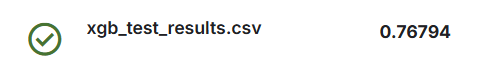

XGBClassifier performs better on cross-validation. Kaggle test is better than Random Forest but worse than bagging.

XGBClassifier:
- accuracy score on cross-validation: 0.8406866416978778
- accuracy score on all train data: 0.8518518518518519

RandomForestClassifier:
- accuracy score on cross-validation: 0.8338701622971285
- accuracy score on all train data: 0.856341189674523

# LightGBM

We saw on xgb example that titanic dataset is small and early stopping doesn't improve time much. So let's just use grid search without early stopping

In [27]:
categorical_feature = ['Sex', 'Embarked', 'title', 'ticket_prefix', 'cabin_letter']

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scoring = make_scorer(accuracy_score)

def make_categorical_columns(df):
    df_lgb_adjusted = df.copy()
    for col in categorical_feature:
        df_lgb_adjusted[col] = df_lgb_adjusted[col].astype('category')
        
    return df_lgb_adjusted

lgb_train = lgb.Dataset(make_categorical_columns(train_X), label=train_y, free_raw_data=False)
lgb_test = lgb.Dataset(make_categorical_columns(test_X), free_raw_data=False)

In [33]:
lgb_params1 = {
    'objective': 'binary',
    'metric': 'binary_logloss', # 'auc'
    'boosting_type': 'gbdt',
    'verbosity': -1    
}
lgb_rounds = 1000
    
lgb.cv(lgb_params1, lgb_train, lgb_rounds, folds=cv, callbacks=[lgb.early_stopping(10), lgb.log_evaluation(period=100)])

c:\Python\envs\ds1\Lib\site-packages\sklearn\model_selection\_split.py:848: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	cv_agg's valid binary_logloss: 0.419394 + 0.0562488


{'valid binary_logloss-mean': [0.6242402271531206,
  0.5916523696244018,
  0.5651617236140762,
  0.5433609407047462,
  0.5255010764243424,
  0.5093997546958545,
  0.4957701812175313,
  0.48446732861354114,
  0.4736955539160556,
  0.4648627774419526,
  0.4591776260979813,
  0.4529173001165433,
  0.4474000295703641,
  0.44221821229185937,
  0.43896423009360735,
  0.4356811165872732,
  0.43245944911375167,
  0.4302967829470673,
  0.42809448161808383,
  0.426630011783668,
  0.4257919005320461,
  0.4240717661832831,
  0.4235195945181089,
  0.422637162798273,
  0.42155605827208575,
  0.42060759351886967,
  0.42020969293883137,
  0.41939350353111615],
 'valid binary_logloss-stdv': [0.005677867215867185,
  0.010986900788293983,
  0.015582730246821695,
  0.01954438929784988,
  0.023442323760077936,
  0.025246779386797452,
  0.028255903570766475,
  0.030466202949868352,
  0.0325334103904123,
  0.03394967324436444,
  0.037038896824402985,
  0.03907359867214575,
  0.0406063123311481,
  0.042780491

In [54]:
lgb_params2 = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    
    'learning_rate': 0.1,
    
    'min_data_in_leaf': 5,
    'min_data_per_group': 20,
    'num_leaves': 8,
    
    'colsample_bytree': 0.4, # such small value gives the best score
    # 'subsample': 1,
        
    'cat_smooth': 10, 
    'verbosity': -1    
}
# best_params: {'boosting_type': 'gbdt', 'cat_smooth': 10, 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'metric': 'binary_logloss', 'min_data_in_leaf': 5, 'min_data_per_group': 20, 'num_leaves': 8, 'subsample': 0.4}
# accuracy score on cross-validation: 0.8338202247191011
lgb_rounds = 1000
    
lgb_results2 = lgb.cv(lgb_params2, lgb_train, lgb_rounds, folds=cv, callbacks=[lgb.early_stopping(10), lgb.log_evaluation(period=100)])
lgb_rounds_ = len(list(lgb_results2.items())[0][1])

lgbClassifier = lgb.LGBMClassifier(random_state=3, **lgb_params2, lgb_rounds=lgb_rounds_)
lgbClassifier_results = cross_val_score(lgbClassifier, make_categorical_columns(train_X), train_y, cv=cv, scoring=scoring)
print(f'accuracy score on cross-validation: {lgbClassifier_results.mean()}')

lgbClassifier.fit(make_categorical_columns(train_X), train_y)
lgb1_train_y_predict = (lgbClassifier.predict(make_categorical_columns(train_X)) >= 0.5).astype(int)
lgb1_train_score = accuracy_score(lgb1_train_y_predict, np.array(train_y))
print(f'accuracy score on all train data: {lgb1_train_score}')


c:\Python\envs\ds1\Lib\site-packages\sklearn\model_selection\_split.py:848: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[57]	cv_agg's valid binary_logloss: 0.404405 + 0.0538701
accuracy score on cross-validation: 0.8338202247191011
accuracy score on all train data: 0.8900112233445566


In [180]:
lgbm_test_results = test_X.copy()
lgbm_test_results['Survived'] = (lgbClassifier.predict(make_categorical_columns(test_X)) >= 0.5).astype(int)
lgbm_test_results['Survived'].to_csv('lgbm_test_results.csv', index=True)

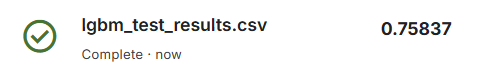

LGBMClassifier performs slightly worse than XGBClassifier.

LGBMClassifier:
- accuracy score on cross-validation: 0.8338202247191011
- accuracy score on all train data: 0.8900112233445566

XGBClassifier:
- accuracy score on cross-validation: 0.8406866416978778
- accuracy score on all train data: 0.8518518518518519

# Cat Boost

In [55]:
cat_train = ctb.Pool(make_categorical_columns(train_X), train_y, cat_features=categorical_feature)
cat_test = ctb.Pool(make_categorical_columns(test_X), cat_features=categorical_feature)

In [57]:
cat_parameters1 = {
    "loss_function": "Logloss",
    "eval_metric": "Accuracy",
    
    "iterations": 1000,
}

cat_result_1 = ctb.cv(cat_train, cat_parameters1, folds=cv, seed=3, verbose_eval=100, plot=True)

c:\Python\envs\ds1\Lib\site-packages\sklearn\model_selection\_split.py:848: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/10]
0:	learn: 0.8064919	test: 0.8111111	best: 0.8111111 (0)	total: 183ms	remaining: 3m 2s
100:	learn: 0.8426966	test: 0.8666667	best: 0.8666667 (24)	total: 4.27s	remaining: 38s
200:	learn: 0.8751561	test: 0.8777778	best: 0.8888889 (125)	total: 8.36s	remaining: 33.2s
300:	learn: 0.8938826	test: 0.8777778	best: 0.8888889 (125)	total: 12.4s	remaining: 28.9s
400:	learn: 0.9051186	test: 0.9000000	best: 0.9000000 (376)	total: 16.8s	remaining: 25s
500:	learn: 0.9126092	test: 0.9000000	best: 0.9000000 (376)	total: 21s	remaining: 20.9s
600:	learn: 0.9275905	test: 0.9000000	best: 0.9000000 (376)	total: 25.2s	remaining: 16.7s
700:	learn: 0.9325843	test: 0.9111111	best: 0.9111111 (641)	total: 29.6s	remaining: 12.6s
800:	learn: 0.9400749	test: 0.9111111	best: 0.9111111 (641)	total: 34.7s	remaining: 8.61s
900:	learn: 0.9438202	test: 0.9111111	best: 0.9111111 (641)	total: 39.4s	remaining: 4.32s
999:	learn: 0.9513109	test: 0.9111111	best: 0.9222222 (913)	total: 43.6s	remaining: 0us

In [60]:
cat_result_1.loc[cat_result_1["test-Accuracy-mean"] == cat_result_1["test-Accuracy-mean"].max()]

,iterations,test-Accuracy-mean,test-Accuracy-std,train-Accuracy-mean,train-Accuracy-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
432,432,0.832697,0.035941,0.917444,0.007074,0.411753,0.063254,0.252655,0.008744


In [64]:
catboost_model = ctb.CatBoostClassifier(**cat_parameters1)
catboost_model.fit(cat_train, verbose_eval=100, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.009807
0:	learn: 0.7923681	total: 83.5ms	remaining: 1m 23s
100:	learn: 0.8327722	total: 4.16s	remaining: 37s
200:	learn: 0.8361392	total: 8.38s	remaining: 33.3s
300:	learn: 0.8496072	total: 12.8s	remaining: 29.6s
400:	learn: 0.8653199	total: 17s	remaining: 25.4s
500:	learn: 0.8675645	total: 21.3s	remaining: 21.2s
600:	learn: 0.8765432	total: 25.5s	remaining: 16.9s
700:	learn: 0.8843996	total: 29.5s	remaining: 12.6s
800:	learn: 0.8922559	total: 33.7s	remaining: 8.37s
900:	learn: 0.8967452	total: 38s	remaining: 4.18s
999:	learn: 0.9001122	total: 42.4s	remaining: 0us


In [65]:
accuracy_score(catboost_model.predict(cat_train), train_y)

0.8686868686868687

In [67]:
cat_test_results = test_X.copy()
cat_test_results['Survived'] = catboost_model.predict(cat_test)
cat_test_results['Survived'].to_csv('cat_test_results.csv', index=True)

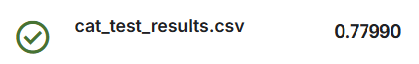

CatBoost takes too long to train which makes it hard to keep tunning parameters. Default parameters performed quite well - on train dataset accuracy score is about the same as other boosting methods, on kaggle test it gave the highest score.

CatBoost:
- accuracy score on cross-validation: 0.832697
- accuracy score on all train data: 0.8686868686868687

LGBMClassifier:
- accuracy score on cross-validation: 0.8338202247191011
- accuracy score on all train data: 0.8900112233445566

XGBClassifier:
- accuracy score on cross-validation: 0.8406866416978778
- accuracy score on all train data: 0.8518518518518519

RandomForestClassifier
- Best_params {'max_depth': 5, 'max_features': 0.75, 'max_samples': 0.75, 'min_samples_leaf': 3, 'n_estimators': 100}
- accuracy score on cross-validation: 0.8338701622971285
- accuracy score on all train data: 0.856341189674523

CustomBaggingClassifier
- accuracy score on cross-validation: 0.8237827715355805
- accuracy score on all train data: 0.8518518518518519

BaggingClassifier
- accuracy score on cross-validation: 0.8316354556803995
- accuracy score on all train data: 0.8574635241301908

- Bagging params {'max_features': 0.9, 'max_samples': 0.6, 'n_estimators': 200}
- Base classifier parameters {'max_depth': 5, 'min_samples_leaf': 3}

DecisionTree
- Best_params {'max_depth': 5, 'min_samples_leaf': 3}
- accuracy score on cross-validation: 0.8226716604244695
- accuracy score on all train data: 0.8507295173961841